<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Pui/From%20Colab/European_Call_1stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5319      0 --:--:-- --:--:-- --:--:--  5319
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 42 kB/s 
     |████████████████████████████████| 1.0 MB 39.8 MB/s 
+ set +ex
Installation succeeded!


### Deep Learning Barrier Option

We used Numba and CuPy in the previous notebook to run Monte Carlo simulation to determine the price of the Asian Barrier option. A Monte Carlo simulation needs millions of paths to get an accurate answer which is computationally intensive. [Ryan et al (2018)](https://arxiv.org/abs/1809.02233) showed that a deep learning model can be trained to value derivatives. The deep learning model is accurate and very fast, capable of producing valuations a million times faster than traditional models. In the this notebook, we will use a fully connected network to learn the pricing mode of the Asian Barrier option. Monte Carlo simulation is used as pricing ground truth for the training. We use the same Asian Barrier Option model as last notebook with parameters listed as following:

```
T - Maturity (yrs.)
S - Spot (usd)
K - Strike (usd)
sigma - Volatility (per.)
r - Risk Free Rate (per.)
mu - Stock Drift Rate (per.)
B - Barrier (usd)
```

### Batched Data generation

The dataset is an important part of the Deep learning training. We will modify the previous single Asian Barrier Option pricing code to handle a batch of Barrier Option pricing. 

In [ ]:
#@title
###Test: Judy's new X code
#N_STOCKS = 3

In [ ]:
#@title
#X = cupy.array([])
#for i in range(0,N_STOCKS):
  #X =  cupy.concatenate((X,cupy.array([1,1]), cupy.random.rand(3),cupy.array([1])))
#X = X.reshape(N_STOCKS,6)
#X

In [ ]:
#@title
#X = X * ((cupy.array([200.0, 0, 200.0, 0.4, 0.2, 0.2] * N_STOCKS, dtype = cupy.float32)).reshape(N_STOCKS, 6))
#X

### Train(Erin Version)

In [ ]:
# ################################# TEST ########################################
# %%writefile cupy_dataset.py

# import numba
# from numba import cuda
# import random
# import cupy
# import numpy as np
# import math
# import time
# import torch
# cupy.cuda.set_allocator(None)
# from torch.utils.dlpack import from_dlpack

# @cuda.jit
# def batch_barrier_option(d_s, T, K, B, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
#     # ii - overall thread index
#     ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
#     stride = cuda.gridDim.x * cuda.blockDim.x
#     tmp3 = math.sqrt(T/N_STEPS)
#     for i in range(ii, N_PATHS * N_BATCH, stride):
#         batch_id = i // N_PATHS
#         path_id = i % N_PATHS
#         tmp1 = mu[batch_id]*T/N_STEPS
#         tmp2 = math.exp(-r[batch_id]*T)
#         running_average = 0.0
#         s_curr = S0[batch_id]
#         for n in range(N_STEPS):
#             s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price
#             running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
#             if i==0 and batch_id == 2:
#                 print(s_curr)
#             if running_average <= B[batch_id]: # if reach barrier, drop out the path
#                 break
#         payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
#         d_s[i] = tmp2 * payoff

# class NumbaOptionDataSet(object):
    
#     def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):  # 3 stocks
#         self.num = 0
#         self.max_length = max_len
#         self.N_PATHS = number_path
#         self.N_STEPS = 365
#         self.N_BATCH = batch
#         self.N_STOCKS = stocks
#         self.T = np.float32(1.0)
#         self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
#         self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
#         self.number_of_threads = threads
#         cupy.random.seed(seed)
        
#     def __len__(self):
#         return self.max_length
        
#     def __iter__(self):
#         self.num = 0
#         return self
    
#     def __next__(self):
#         if self.num > self.max_length:
#             raise StopIteration
        
#         Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
#         paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
#         for op in range(self.N_BATCH):
          
#           X = cupy.array([])
#           K_rand = cupy.random.rand(1)[0]
#           B_rand = cupy.random.rand(1)[0]
#           r_rand = cupy.random.rand(1)[0]
#           for i in range(0,self.N_STOCKS):
#             X =  cupy.concatenate((X,cupy.array([K_rand,B_rand]), cupy.random.rand(3),cupy.array([r_rand]))) #[K,B,S0,sigma,mu,r], K B r are shared
#           X = X.reshape(self.N_STOCKS,6)
#           X = X * ((cupy.array([200.0, 0.1, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
#           #X = cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)
#           #X = 0.9 + cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)*0.1
#           # scale the [0, 1) random numbers to the correct range for each of the option parameters
#           #X = (X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6)

#           # make sure the Barrier is smaller than the Strike price
#           # X[:, 1] = X[:, 0] * X[:, 1]
#           for i in range(self.N_STOCKS):
#             paras[op,i*6:(i+1)*6] = X[i,:]

#           stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
#           rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

#           #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
#           #cupy.fill_diagonal(stocks_randoms_cov, rho)

#           #stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
#           stocks_randoms_cov = cupy.array([1] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)  #Covariance
#           cupy.fill_diagonal(stocks_randoms_cov, 1)

#           num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
#           randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
#                                                         num_of_randoms_each_stock, dtype=cupy.float32)
#           b1_r = randoms_gpu[:,0]
#           b2_r = randoms_gpu[:,1]
#           randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#           interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
#           for i in range(interval):
#             if i % 2 == 0:
#                 ind = int(i/2)
#                 randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
#             else:
#                 ind = int(i//2)
#                 randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

#           randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
#           batch_barrier_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, self.T, X[:, 0], 
#                                 X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
#           o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
#           Y[op] = o.mean(axis = 0).mean()

#         self.num += 1
#         return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



# # ds = NumbaOptionDataSet(10, number_path=100000, batch=3, seed=random.randint(0,100), stocks=5)
# # for i in ds:
# #     print(i[0])
# ################################# TEST ########################################

### Train (European Call option)

In [3]:
################################# TEST ########################################
%%writefile cupy_dataset.py

import numba
from numba import cuda
import random
import cupy
import numpy as np
import math
import time
import torch
cupy.cuda.set_allocator(None)
from torch.utils.dlpack import from_dlpack

@cuda.jit
def European_call_option(d_s, T, K, S0, sigma, mu, r, d_normals, N_STEPS, N_PATHS, N_BATCH):
    # ii - overall thread index
    ii = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    stride = cuda.gridDim.x * cuda.blockDim.x
    #tmp3 = math.sqrt(T/N_STEPS)
    for i in range(ii, N_PATHS * N_BATCH, stride):
        batch_id = i // N_PATHS
        path_id = i % N_PATHS
        h = T[batch_id] / N_STEPS
        tmp1 = r[batch_id]*T[batch_id]/N_STEPS 
        tmp2 = math.exp(-r[batch_id]*T[batch_id]) # discount
        tmp3 = math.sqrt(T[batch_id]/N_STEPS)
        #running_average = 0.0
        s_curr = S0[batch_id]
        for n in range(N_STEPS):
          s_curr += tmp1 * s_curr + sigma[batch_id]*s_curr*tmp3*d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH] # stock price #save2
          #s_curr = s_curr * math.exp((r[batch_id] - (1/2)*sigma[batch_id]**2)*h + sigma[batch_id] * tmp3 * d_normals[path_id + batch_id * N_PATHS + n * N_PATHS * N_BATCH]) #save1
          #running_average = running_average + 1.0/(n + 1.0) * (s_curr - running_average) # average of the path
          #if i==0 and batch_id == 2:
          #    print(s_curr)
          #if running_average <= B[batch_id]: # if reach barrier, drop out the path
          #    break
        #payoff = running_average - K[batch_id] if running_average > K[batch_id] else 0
        payoff = s_curr - K[batch_id] if s_curr > K[batch_id] else 0
        d_s[i] = tmp2 * payoff

class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, threads=512, seed=15, stocks=3):  # 3 stocks
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        #self.N_STEPS = 365
        self.N_STEPS = 10000
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        #self.T = np.float32(1.0)
        self.output = cupy.zeros(self.N_STOCKS*self.N_PATHS, dtype=cupy.float32) 
        self.number_of_blocks = (self.N_PATHS * self.N_STOCKS - 1) // threads + 1
        self.number_of_threads = threads
        cupy.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num > self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)
        #paras = cupy.zeros((self.N_BATCH, self.N_STOCKS * 5), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          X = cupy.array([])
          #T_rand = cupy.random.rand(1)[0]
          #K_rand = cupy.random.rand(1)[0]
          #B_rand = cupy.random.rand(1)[0]
          #r_rand = cupy.random.rand(1)[0]
          for i in range(0, self.N_STOCKS):
            #X =  cupy.concatenate((X, cupy.array([K_rand,B_rand]), cupy.random.rand(3), cupy.array([r_rand]))) #[K,B,S0,sigma,mu,r], K B r are shared
            #X = cupy.concatenate((X, cupy.random.rand(2), cupy.array([200]), cupy.random.rand(3))) #[T, K, S0, sigma, mu, r]
            #X = cupy.concatenate((X, cupy.random.rand(6))) #[T, K, S0, sigma, mu, r]
            X = cupy.concatenate((X, cupy.array([1]), cupy.random.rand(5))) #[T, K, S0, sigma, mu, r]
          
          X = X.reshape(self.N_STOCKS, 6)
          #X = X * ((cupy.array([200.0, 0.1, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          #[T, K, S0, sigma, mu, r]
          X = X * ((cupy.array([1.0, 150.0, 150.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6))
          #X = cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)
          #X = 0.9 + cupy.random.rand(6 * self.N_STOCKS, dtype=cupy.float32)*0.1
          # scale the [0, 1) random numbers to the correct range for each of the option parameters
          #X = (X * cupy.array([200.0, 0.99, 200.0, 0.4, 0.2, 0.2] * self.N_STOCKS, dtype = cupy.float32)).reshape(self.N_STOCKS, 6)

          # make sure the Barrier is smaller than the Strike price
          # X[:, 1] = X[:, 0] * X[:, 1]
          for i in range(self.N_STOCKS):
            paras[op,i*6:(i+1)*6] = X[i,:]
            #paras[op, i*5:(i+1)*5] = X[i,:]

          stocks_randoms_mean = cupy.zeros(self.N_STOCKS, dtype = cupy.float32)
          rho = cupy.random.normal(0, 1, self.N_STOCKS, dtype = cupy.float32)

          #stocks_randoms_cov = cupy.ones((self.N_STOCKS, self.N_STOCKS), dtype = cupy.float32)
          #cupy.fill_diagonal(stocks_randoms_cov, rho)

          #stocks_randoms_cov = (-0.99 + cupy.random.rand(self.N_STOCKS*self.N_STOCKS, dtype=cupy.float32)*2*0.99).reshape(self.N_STOCKS,self.N_STOCKS)
          if self.N_STOCKS != 1:
            stocks_randoms_cov = cupy.array([1] * self.N_STOCKS*self.N_STOCKS, dtype = cupy.float32).reshape(self.N_STOCKS,self.N_STOCKS)  #Covariance
            cupy.fill_diagonal(stocks_randoms_cov, 1)

            num_of_randoms_each_stock = self.N_PATHS * self.N_STEPS
            randoms_gpu = cupy.random.multivariate_normal(stocks_randoms_mean, stocks_randoms_cov,
                                                          num_of_randoms_each_stock, dtype=cupy.float32)
            b1_r = randoms_gpu[:,0]
            b2_r = randoms_gpu[:,1]
            randoms = cupy.zeros(self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
            interval = int((self.N_PATHS * self.N_STEPS * self.N_STOCKS) / self.N_PATHS)
            for i in range(interval):
              if i % 2 == 0:
                  ind = int(i/2)
                  randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b1_r[ind:(ind+self.N_PATHS)]
              else:
                  ind = int(i//2)
                  randoms[i*self.N_PATHS:(i+1)*self.N_PATHS] = b2_r[ind:(ind+self.N_PATHS)]

          if self.N_STOCKS == 1:
            randoms = cupy.random.normal(0, 1, self.N_STOCKS * self.N_PATHS * self.N_STEPS, dtype=cupy.float32)
          
          European_call_option[(self.number_of_blocks,), (self.number_of_threads,)](self.output, X[:, 0], 
                                X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5], randoms, self.N_STEPS, self.N_PATHS, self.N_STOCKS)
          
          o = self.output.reshape(self.N_STOCKS, self.N_PATHS)
          Y[op] = o.mean(axis = 0).mean()

        self.num += 1
        return (from_dlpack(paras.toDlpack()), from_dlpack(Y.toDlpack()))



#ds = NumbaOptionDataSet(2, number_path = 100000, batch = 2, seed = random.randint(0,100), stocks=1)
#for i in ds:
#    print(i)
################################# TEST ########################################

Writing cupy_dataset.py


### Model
To map the option parameters to price, we use 6 layers of fully connected neural network with hidden dimension 512 as inspired by [this paper](https://arxiv.org/abs/1809.02233). Writing this DL price model into a file `model.py`:-

### Modified Model

In [4]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


# class Net(nn.Module):

#     def __init__(self, hidden=1024):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(18, hidden) # remember to change this!
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fc3 = nn.Linear(hidden, hidden)
#         self.fc4 = nn.Linear(hidden, hidden)
#         self.fc5 = nn.Linear(hidden, hidden)
#         self.fc6 = nn.Linear(hidden, 1)
#         self.register_buffer('norm',
#                              torch.tensor([200.0, 0.1, 200.0, 0.4, 0.2, 0.2]*3)) # don't use numpy here - will give error later

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([1.0, 150.0, 150.0, 0.4, 0.2, 0.2]*1)) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


As we know the random parameters' scaling factors, the input parameters are first scaled back to a range of (0-1) by dividing them by (200.0, 198.0, 200.0, 0.4, 0.2, 0.2). Then they are projected 5 times to the hidden dimension of 512 after the `ELu` activation function. `ELu` is chosen because we need to compute the second order differentiation of the parameters. If use ReLu, the second order differentiation will always be zero. The last layer is a linear layer that maps the hidden dimension to the predicted option price. 

For training, we use [Ignite](https://github.com/pytorch/ignite) which is a high-level library to train neural networks in PyTorch. We use `MSELoss` as the loss function, `Adam` as the optimizer and `CosineAnnealingScheduler` as the learning rate scheduler. The following code is feeding the random option data to the pricing model to train it.

### Train

In [5]:
!pip install pytorch-ignite

     |████████████████████████████████| 232 kB 13.4 MB/s 


In [10]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len = 10000, number_path = 1024, batch = 4800)
# dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024, batch = 32, stocks = 3)
dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024*4, batch = 32, stocks = 1)


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=1000)

loss 1524.402587890625 average time 0.0195295595500113 iter num 20
loss 1077.0811767578125 average time 0.011225993750008456 iter num 40
loss 988.1787109375 average time 0.008436475933342536 iter num 60
loss 663.1386108398438 average time 0.007055909300004259 iter num 80
loss 779.9702758789062 average time 0.006208462930003406 iter num 100
loss 46.67201232910156 average time 0.01940017870001043 iter num 20
loss 22.54370880126953 average time 0.011123689875000764 iter num 40
loss 19.555679321289062 average time 0.008377782550002166 iter num 60
loss 12.625123977661133 average time 0.006992404450001289 iter num 80
loss 13.249013900756836 average time 0.006201642740002171 iter num 100
loss 10.894521713256836 average time 0.019117149949994427 iter num 20


Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

$2365$ seconds The loss is keeping decreasing which means the pricing model can predict the option prices better. It takes about $12ms$ to compute one mini-batch in average, In the following sections, we will try to expore the full potentials of the GPU to accelerate the training.

**Save Model**

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
import torch
model_save_name = 'EuCall2_const_T_1_4.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import torch
model_save_name = 'EuCall2_const_T_1_5.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

odict_keys(['norm', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias', 'fc6.weight', 'fc6.bias'])


In [8]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

Net(
  (fc1): Linear(in_features=6, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=1024, bias=True)
  (fc6): Linear(in_features=1024, out_features=1, bias=True)
)


### Continue to train model

In [70]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len = 10000, number_path = 1024, batch = 4800)
# dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024, batch = 32, stocks = 3)
dataset = NumbaOptionDataSet(max_len = 100, number_path = 51200, batch = 32, stocks = 1)


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs=20)

model_save_name = 'EuCall2_const_T_1_5.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

loss 3.739781379699707 average time 0.12451430550036094 iter num 20
loss 0.25414562225341797 average time 0.06368929530017339 iter num 40
loss 0.0736747533082962 average time 0.04341023393350649 iter num 60
loss 0.02601216360926628 average time 0.03326455397518657 iter num 80
loss 0.015108730643987656 average time 0.02718651799015788 iter num 100
loss 0.06354039162397385 average time 0.12845637885002362 iter num 20
loss 0.06600115448236465 average time 0.06567673607505639 iter num 40
loss 0.020860284566879272 average time 0.04474277910009429 iter num 60
loss 0.01636497862637043 average time 0.034273154650145445 iter num 80
loss 0.017406577244400978 average time 0.027985578600109876 iter num 100
loss 0.023038573563098907 average time 0.12883953089994976 iter num 20
loss 0.04388163611292839 average time 0.06584414339977229 iter num 40
loss 0.030836032703518867 average time 0.04486050916645278 iter num 60
loss 0.0171180572360754 average time 0.03437326083728749 iter num 80
loss 0.05121181

### Inference and Greeks

We can load the model parameters and use it to do inference

In [25]:
import torch
inputs = torch.tensor([[1, 110.0, 111.0, 0.35, 0.1, 0.05]*1]).cuda()
model(inputs.float())

tensor([[18.3762]], device='cuda:0', grad_fn=<AddmmBackward>)

One of the benefits of building a deep learning model is that the [Greeks](<https://en.wikipedia.org/wiki/Greeks_(finance)#First-order_Greeks>) can be easily computed. 
We just need to take advantage of the auto-grad feature in Pytorch. We can use `grad` function to compute the first order differentiation for parameters 'K, B, S0, sigma, mu, r'

In [11]:
inputs = torch.tensor([[10, 110.0, 110.0, 0.35, 0.1, 0.05]*1]).cuda()
inputs.requires_grad = True
x = model(inputs.float())
x.backward()
first_order_gradient = inputs.grad
first_order_gradient

tensor([[  7.0903,  -0.4984,   0.4925,  -8.6538, -19.4499,  -3.3166]],
       device='cuda:0')

Here we are going to plot the Delta graph:-

# Delta

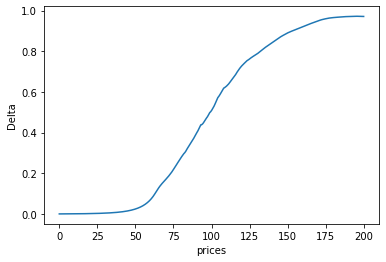

In [30]:
##Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S):
    # inputs = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    inputs = torch.tensor([[1, 110.0, S, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]
prices = np.arange(0, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

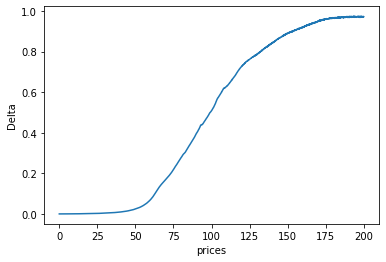

In [31]:
## Using Finite Difference, Change only 1 S0 at a time
%matplotlib inline
import numpy as np
def compute_delta(S):
    epsilon = 0.01
    #inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    #inputs2 = torch.tensor([[110.0, 0.0, S + epsilon, 0.35, 0.1, 0.05] + ([110.0, 0.0, 110.0, 0.35, 0.1, 0.05]*2)]).cuda()
    inputs1 = torch.tensor([1, 110, S, 0.35, 0.1, 0.05]).cuda()
    inputs2 = torch.tensor([1, 110, S + epsilon, 0.35, 0.1, 0.05]).cuda()
    delta = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return delta
prices = np.arange(0, 200, 0.1)
deltas = []
for p in prices:
    deltas.append(compute_delta(p).item())
fig = pylab.plot(prices, deltas)
pylab.xlabel('prices')
pylab.ylabel('Delta')
fig

In [32]:
compute_delta(110)

tensor([0.6296], device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
# ##Using Finite Difference, Change 3 S0 at a time
# %matplotlib inline
# import numpy as np
# def compute_delta(S):
#     epsilon = 0.01
#     inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*3]).cuda()
#     inputs2 = torch.tensor([[110.0, 0.0, S + epsilon, 0.35, 0.1, 0.05]*3]).cuda()
#     delta = (model(inputs2.float()) - model(inputs1.float()))/epsilon
#     return delta
# prices = np.arange(10, 200, 0.1)
# deltas = []
# for p in prices:
#     deltas.append(compute_delta(p).item())
# fig = pylab.plot(prices, deltas)
# pylab.xlabel('prices')
# pylab.ylabel('Delta')
# fig

# Gamma

Calculating the second order derivative is easy in PyTorch too. We just need to apply the `grad` function twice. Use this mechanism, we can calculate the second order derivatives $\frac{\partial^2 P}{\partial K \partial S_0}$, $\frac{\partial^2 P}{\partial B \partial S_0}$, $\frac{\partial^2 P}{\partial S_0^2}$, $\frac{\partial^2 P}{\partial \sigma \partial S_0}$, $\frac{\partial^2 P}{\partial \mu \partial S_0}$, $\frac{\partial^2 P}{\partial r \partial S_0}$ in the following example.

In [33]:
import torch
from torch import Tensor
from torch.autograd import Variable
from torch.autograd import grad
from torch import nn

inputs = torch.tensor([[1, 110, 110, 0.35, 0.1, 0.05]]).cuda()
inputs.requires_grad = True
x = model(inputs)

# instead of using loss.backward(), use torch.autograd.grad() to compute gradients
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.grad
loss_grads = grad(x, inputs, create_graph=True)
drv = grad(loss_grads[0][0][2], inputs)
drv

(tensor([[-0.1365, -0.0071,  0.0071,  0.0862, -0.0257,  0.8277]],
        device='cuda:0'),)

Gamma is the second order differenation of `S`. We can plot the the Gamma curve as a function of the stock price

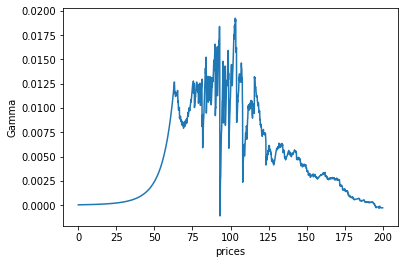

In [40]:
##Using gradient, Change only 1 S0 at a time
import pylab
import numpy as np
def compute_gamma(S):
    inputs = torch.tensor([[1, 110, S, 0.35, 0.1, 0.05]]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    loss_grads = grad(x, inputs, create_graph=True)
    drv = grad(loss_grads[0][0][2], inputs)
    return drv[0][0][2]

prices = np.arange(0, 200, 0.1)
gammas = []
for p in prices:
    gammas.append(compute_gamma(p).item())
fig2 = pylab.plot(prices, gammas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig2

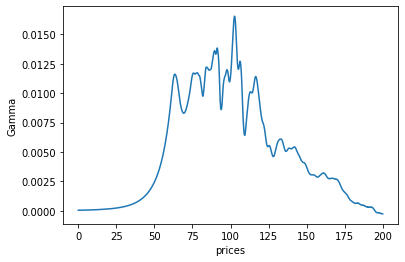

In [41]:
##Using Finite Difference, Change only 1 S0 at a time
%matplotlib inline
import numpy as np
def compute_gamma(S):
    epsilon = 2
    inputs1 = torch.tensor([[1, 110, S, 0.35, 0.1, 0.05]]).cuda()
    inputs2 = torch.tensor([[1, 110, S + epsilon, 0.35, 0.1, 0.05]]).cuda()
    inputs3 = torch.tensor([[1, 110, S - epsilon, 0.35, 0.1, 0.05]]).cuda()
    gamma = (model(inputs2.float()) - 2*model(inputs1.float()) + model(inputs3.float()))/(epsilon**2)
    return gamma
prices = np.arange(0, 200, 0.1)
gammas = []
for p in prices:
    gammas.append(compute_gamma(p).item())
fig = pylab.plot(prices, gammas)
pylab.xlabel('prices')
pylab.ylabel('Gamma')
fig

In [ ]:
# ##Using Finite Difference, Change 3 S0 at a time
# %matplotlib inline
# import numpy as np
# def compute_gamma(S):
#     epsilon = 0.5
#     inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*3]).cuda()
#     inputs2 = torch.tensor([[110.0, 0.0, S + epsilon, 0.35, 0.1, 0.05]*3]).cuda()
#     inputs3 = torch.tensor([[110.0, 0.0, S - epsilon, 0.35, 0.1, 0.05]*3]).cuda()
#     gamma = (model(inputs2.float()) - 2*model(inputs1.float()) + model(inputs3.float()))/(epsilon**2)
#     return gamma
# prices = np.arange(10, 200, 0.1)
# gammas = []
# for p in prices:
#     gammas.append(compute_gamma(p).item())
# fig = pylab.plot(prices, gammas)
# pylab.xlabel('prices')
# pylab.ylabel('Gamma')
# fig

# Vega

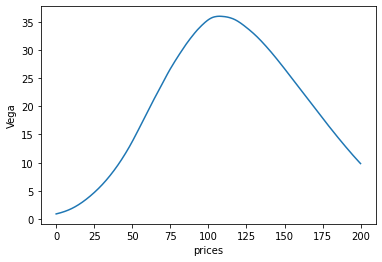

In [42]:
##Using gradient, Change only 1 S0 at a time
# vega
%matplotlib inline
import numpy as np
def compute_vega(S):
    epsilon = 0.5
    inputs1 = torch.tensor([[1, 110, S, 0.35, 0.1, 0.05]]).cuda()
    inputs2 = torch.tensor([[1, 110, S, 0.35 + epsilon, 0.1, 0.05]]).cuda()
    vega = (model(inputs2.float()) - model(inputs1.float()))/epsilon
    return vega
prices = np.arange(0, 200, 0.1)
vegas = []
for p in prices:
    vegas.append(compute_vega(p).item())
fig = pylab.plot(prices, vegas)
pylab.xlabel('prices')
pylab.ylabel('Vega')
fig

In [ ]:
# ##Using Finite Difference, Change 3 S0 at a timev
# # vega
# %matplotlib inline
# import numpy as np
# def compute_vega(S):
#     epsilon = 0.5
#     inputs1 = torch.tensor([[110.0, 0.0, S, 0.35, 0.1, 0.05]*3]).cuda()
#     inputs2 = torch.tensor([[110.0, 0.0, S, 0.35 + epsilon, 0.1, 0.05]*3]).cuda()
#     vega = (model(inputs2.float()) - model(inputs1.float()))/epsilon
#     return vega
# prices = np.arange(10, 200, 0.1)
# vegas = []
# for p in prices:
#     vegas.append(compute_vega(p).item())
# fig = pylab.plot(prices, vegas)
# pylab.xlabel('prices')
# pylab.ylabel('Vega')
# fig

[Implied volatility](https://en.wikipedia.org/wiki/Implied_volatility) is the forecasted volatility of the underlying asset based on the quoted prices of the option. It is the reverse mapping of price to the option parameter given the model which is hard to do with the Monte Carlo simulation approach. But if we have the deep learning pricing model, it is an easy task. We can first plot the relationship between volatility and the option price

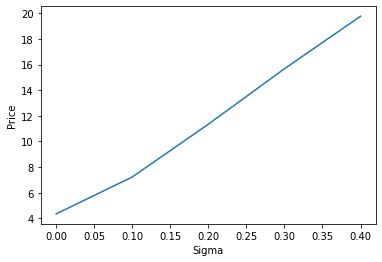

In [43]:
# import pylab
# import numpy as np
# def compute_price(sigma):
#     inputs = torch.tensor([[1, 110, 110, sigma, 0.1, 0.05]]).cuda()
#     x = model(inputs.float())
#     #x = model(inputs)
#     return x.item()
# sigmas = np.arange(0, 0.5, 0.1)
# prices = []
# for s in sigmas:
#     prices.append(compute_price(s))
# fig3 = pylab.plot(sigmas, prices)
# pylab.xlabel('Sigma')
# pylab.ylabel('Price')
# fig3

Given the prices `P`, the implied volatility is the root of the function `compute_price`. We can use bisection to find the root.

In [ ]:
# def bisection_root(small, large, fun, target, EPS=1e-6):
#     if fun(large) - target < 0:
#         print('upper bound is too small')
#         return None
#     if fun(small) - target > 0:
#         print('lower bound is too large')
#         return None
#     while large - small > EPS:
#         mid = (large + small) / 2.0
#         if fun(mid) - target >= 0:
#             large = mid
#         else:
#             small = mid
#     mid = (large + small) / 2.0
#     return mid, abs(fun(mid) - target)
# quoted_price = 16.0
# sigma, err = bisection_root(0, 0.5, compute_price, quoted_price)
# print('implied volativity', sigma, 'error', err)     